<div align="center"><img src="images/hitchcock.png" width=450></div>

# Apple Brand Sentiment at South by Southwest

Nick Gigliotti

[ndgigliotti@gmail.com](ndgigliotti@gmail.com)

[github.com/ndgigliotti](https://github.com/ndgigliotti)

# Business Problem

Apple (fictitiously) wants me to create an explanatory model of positive and negative sentiment in tweets related to the South by Southwest (SXSW) conference in Austin, Texas, 2011. They are specifically interested in what people think about their company, products, and marketing efforts. They've provided me with a labeled Twitter dataset, obtained by one of my coworkers. My objectives are:

1. Build a sentiment classifier for explanatory purposes.
2. Find out what people are saying about Apple (at South by Southwest, 2011).
3. Make some PR recommendations for the period immediately following the event.

# Imports

In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

from sklearn.base import clone
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
    SelectFromModel,
    f_classif,
)

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import (
    Normalizer,
    PolynomialFeatures,
)
from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler,
    ADASYN,
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import bert_sklearn
from bert_sklearn import BertClassifier
import lime
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

10/26/2021 17:51:17 - INFO - blib2to3.pgen2.driver -   Generating grammar tables from C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\blib2to3\Grammar.txt
10/26/2021 17:51:18 - INFO - blib2to3.pgen2.driver -   Writing grammar tables to C:\Users\ndgig\AppData\Local\black\black\Cache\21.9b0\Grammar3.8.12.final.0.pickle
10/26/2021 17:51:18 - INFO - blib2to3.pgen2.driver -   Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\ndgig\\AppData\\Local\\black\\black\\Cache\\21.9b0\\tmpur6nw6w8'
10/26/2021 17:51:18 - INFO - blib2to3.pgen2.driver -   Generating grammar tables from C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\blib2to3\PatternGrammar.txt
10/26/2021 17:51:18 - INFO - blib2to3.pgen2.driver -   Writing grammar tables to C:\Users\ndgig\AppData\Local\black\black\Cache\21.9b0\PatternGrammar3.8.12.final.0.pickle
10/26/2021 17:51:18 - INFO - blib2to3.pgen2.driver -   Writing failed: [Errno 2] No such file or directory: 'C:\\Users\\ndgig\\AppData\\Local\\black\

<IPython.core.display.Javascript object>

## My `tools` Package

I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in `tools.language` and `tools.sklearn.vectorizers` for this project in particular. I'll discuss important developments as they come up.

In [2]:
# Import my modules
from ndg_tools import cleaning, plotting, outliers, utils, language as lang
from ndg_tools.sklearn.vectorizers import FreqVectorizer, VaderVectorizer
from ndg_tools.sklearn import selection

FIT_BERT = False

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<IPython.core.display.Javascript object>

# Overview of Dataset
Since Apple is interested in sentiment analysis on Twitter, I've found a Twitter dataset with crowdsourced sentiment labels. It comes from [CrowdFlower](https://data.world/crowdflower), which has released other similar datasets.

The tweets are related to South by Southwest, an annual conference and arts festival in Austin, Texas. They are from 2011, when Apple launched the iPad 2.

It has only three features: the tweet text, the brand object of the sentiment, and the sentiment. It has only about 9,100 tweets.

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"), encoding="latin1")
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

text   object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\pandas\core\arrays\categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>

The 'Neutral' category dominates the distribution, and 'Negative' is very underrepresented. 'Uncertain' is fortunately a very small 2% of the samples. That's good, because it's completely useless to me.

(0.0, 0.75)

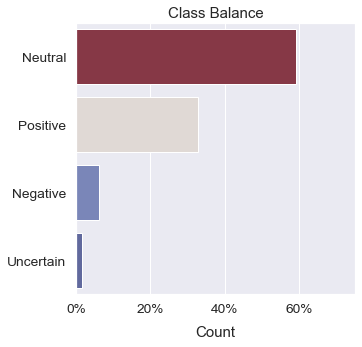

<IPython.core.display.Javascript object>

In [9]:
ax = plotting.countplot(df["emotion"], normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))

I drop the uncertain category, which doesn't have any clear value. I will have to cope with this imbalance later.

In [10]:
# Remove 'Uncertain' and 'Neutral' categories
df["emotion"] = df["emotion"].cat.remove_categories(["Uncertain", "Neutral"])
df

text object_of_emotion  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...            iPhone   
1     @jessedee Know about @fludapp ? Awesome iPad/i...           iOS App   
2     @swonderlin Can not wait for #iPad 2 also. The...              iPad   
3     @sxsw I hope this year's festival isn't as cra...           iOS App   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...            Google   
...                                                 ...               ...   
9088                      Ipad everywhere. #SXSW {link}              iPad   
9089  Wave, buzz... RT @mention We interrupt your re...               NaN   
9090  Google's Zeiger, a physician never reported po...               NaN   
9091  Some Verizon iPhone customers complained their...               NaN   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...               NaN   

       emotion  
0     Negative  
1     Positive  
2     Positive  
3     Negative  
4     Positive  
...        ...  
9088  Positive  
9089       NaN  
9090       NaN  
9091       NaN  
9092       NaN  

[9093 rows x 3 columns]

<IPython.core.display.Javascript object>

'images\\class_balance.svg'

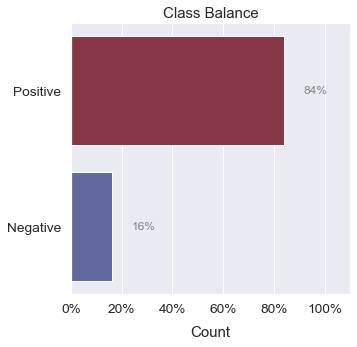

<IPython.core.display.Javascript object>

In [11]:
# Plot class balance
ax = plotting.countplot(df.emotion, normalize=True)
ax.set(title="Class Balance")
plotting.annot_bars(ax, format_spec="{x:.0%}")
ax.set_xlim((0, 1.1))
plotting.save(ax.figure, "images/class_balance.svg")

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [12]:
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5802   63.81     9    0.10   22   0.24
emotion            5545   60.98     2    0.02   22   0.24
text                  1    0.01  9065   99.69   22   0.24

<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [13]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion   357   10.06     9    0.25    9   0.25
text                  0    0.00  3539   99.75    9   0.25
emotion               0    0.00     2    0.06    9   0.25

<IPython.core.display.Javascript object>

Since I don't have anymore null 'emotion' values, I'll go ahead and create a binary 'target' feature.

In [14]:
df["target"] = df["emotion"].replace({"Positive": 1, "Negative": 0}).astype(np.uint8)
df["target"]

0       0
1       1
2       1
3       0
4       1
       ..
9077    1
9079    1
9080    0
9085    1
9088    1
Name: target, Length: 3548, dtype: uint8

<IPython.core.display.Javascript object>

In [15]:
emotion_without_object = cleaning.null_rows(df)
display(emotion_without_object.head(), emotion_without_object.shape)

text object_of_emotion  \
46   Hand-Held Û÷HoboÛª: Drafthouse launches Û÷H...               NaN   
64   Again? RT @mention Line at the Apple store is ...               NaN   
68   Boooo! RT @mention Flipboard is developing an ...               NaN   
103  Know that &quot;dataviz&quot; translates to &q...               NaN   
112  Spark for #android is up for a #teamandroid aw...               NaN   

      emotion  target  
46   Positive       1  
64   Negative       0  
68   Negative       0  
103  Negative       0  
112  Positive       1

(357, 4)

<IPython.core.display.Javascript object>

Looks like some of the NaN values are associated with a positive or negative emotion. Also, it's important to note that some retweets, e.g. 64, 68, have sentimental content beyond that of the original tweet.

In [16]:
lang.readable_sample(
    emotion_without_object.loc[emotion_without_object.target.astype(np.bool_), "text"],
    random_state=456,
)

|      | text                                                                                                                                           |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| 6606 | RT @mention RT @mention Shiny new @mention @mention @eightbit apps, a new @garyvee book, pop-up iPad 2 stores... #SXSW is Christmas for nerds. |
| 4164 | Mad long line for Google party at Maggie Mae's. Hope it's worth it.. but with 80s theme I am very optimistic #sxsw                             |
| 3020 | Apple offers original iPad donation program {link} #entry #friends #house #sxsw                                                                |
| 8114 | #touchingstories giving us the background to STARTING. Great to hear after yesterday's presos on #uncertainty #iPad and/or #tablet #SXSW       |
|  555 | I have my golden tickets f 4sq party Day after the real party #Redbullbpm with Felix da Housecat playing on iPad! #SXSW  {link}                |
| 5501 | RT @mention At #sxsw even the cabbies are tech savvy. That's his iPhone streaming twitter. @mention  {link}                                    |
| 6676 | RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link}                                                           |
|  157 | @mention  #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel                                            |
| 5019 | Here he comes ladies! @mention  @mention  RT @mention I'll be at Austin Convention Center w/  @mention showing my  iPhone game. #SXSW          |
| 8025 | Someone asks Leo about an iPad 2 at #SXSW, he says 'Email me, I'll send you one free'. O.o                                                     |

<IPython.core.display.Javascript object>

These are positive tweets which are missing a brand label. Many of them seem positive&mdash;some towards a brand and some not. The original features names were 'emotion_in_tweet_is_directed_at' and 'is_there_an_emotion_directed_at_a_brand_or_product', which is not consistent with brandless positivity.

In [17]:
# Create regex for finding each brand
re_apple = r"ipad\s*\d?\s*app|ipad|iphone\s*\d?\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find brand/product name occurrences for each brand
findings = lang.locate_patterns(
    [re_apple, re_google],
    docs=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

ipad           125
google         122
apple           76
iphone          57
android         19
iphone app       8
ipad app         4
android app      1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [18]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

original    match  score
46    ios app  iOS App    100
6220   iphone   iPhone    100
6202   iphone   iPhone    100
6180    apple    Apple    100
6180     ipad     iPad    100
...       ...      ...    ...
3055     ipad     iPad    100
3055     ipad     iPad    100
3040     ipad     iPad    100
3269  android  Android    100
9054     ipad     iPad    100

[412 rows x 3 columns]

<IPython.core.display.Javascript object>

In [19]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=4564)

text object_of_emotion  \
646   ÛÏ@mention I'll be at the Austin Convention C...            iPhone   
7285  Google showing off google places with hotpot a...            Google   
4870  Excited to say that I haven't used Foursquare,...            Google   
1805  #sxsw: #15slides: Gruber: keeps on desk Apple ...             Apple   
4976  @mention Oh, oh, oh! Does the iPad come with m...              iPad   
6996  RT @mention Zazzle is officially at #SXSW! Com...            iPhone   
4536  Whoa - line for ipad2 is 3blks long!!! #apple ...              iPad   
2572  That sounds...fantastic. RT @mention At the Go...            Google   
3861  Bad news is it costs $1,000? RT @mention Louis...           iOS App   
7990  Apple to sell iPads in &quot;pop-up&quot; Appl...              iPad   

       emotion  target  
646   Positive       1  
7285  Positive       1  
4870  Positive       1  
1805  Positive       1  
4976  Positive       1  
6996  Positive       1  
4536  Positive       1  
2572  Positive       1  
3861  Negative       0  
7990  Positive       1

<IPython.core.display.Javascript object>

In [20]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

Here's a look at the distributions.

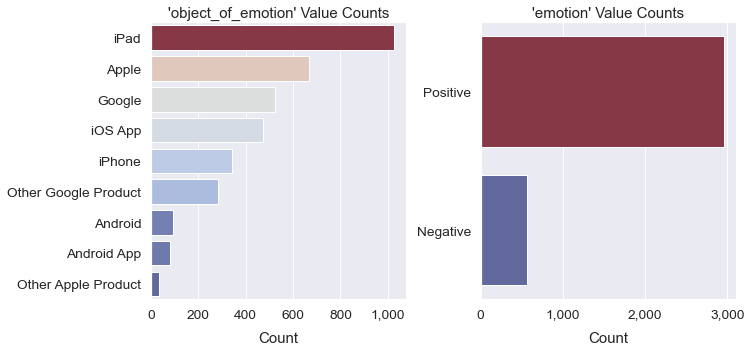

<IPython.core.display.Javascript object>

In [21]:
fig = plotting.countplot(df.select_dtypes("category"))

## Initial Preprocessing

I do some minimal preprocessing on the text before I begin modeling. I transliterate the symbols to ASCII in order to remove accents and remove strange symbols which cannot be decoded properly. Unfortunately there are a lot of strange symbols in this dataset which I can't find a way to decode. I also decode HTML entities like `&mdash;` or `&amp;`, and remove extra space.

In [22]:
df["text"] = lang.force_ascii(df["text"])
df["text"] = lang.decode_html_entities(df["text"])
df["text"] = lang.strip_extra_space(df["text"])
df["text"]

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    "papyrus...sort of like the ipad" - nice! Lol!...
9080    Diller says Google TV "might be run over by th...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: text, Length: 3524, dtype: object

<IPython.core.display.Javascript object>

## Duplicates
There are several duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [23]:
cleaning.dup_rows(df.text).sort_values()

7       #SXSW is just starting, #CTIA is around the co...
3962    #SXSW is just starting, #CTIA is around the co...
1690    #pubcamp #kirkus #sxsw download Qrank on your ...
1691    #pubcamp #kirkus #sxsw download Qrank on your ...
466        Before It Even Begins, Apple Wins #SXSW {link}
468        Before It Even Begins, Apple Wins #SXSW {link}
9       Counting down the days to #sxsw plus strong Ca...
2559    Counting down the days to #sxsw plus strong Ca...
7493    Google Maps Street View car sighting!!! #SXSW ...
7492    Google Maps Street View car sighting!!! #SXSW ...
812     Google to Launch Major New Social Network Call...
813     Google to Launch Major New Social Network Call...
17      I just noticed DST is coming this weekend. How...
8483    I just noticed DST is coming this weekend. How...
8747    Need to buy an iPad2 while I'm in Austin at #s...
20      Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
21      Oh. My

<IPython.core.display.Javascript object>

In [24]:
dups = df["text"].str.replace(r"\bRT\s+", "", regex=True).duplicated()
display(dups.sum())
df = df.loc[~dups].copy()

14

<IPython.core.display.Javascript object>

In [25]:
df.to_json("data/processed_tweets.json")

<IPython.core.display.Javascript object>

# Modeling

## Train-Test-Split

I perform the train-test split which I'll use throughout my modeling process. I let `X` and its derivatives be `DataFrame` objects because I plan to use a `ColumnTransformer` to process the two columns separately.

In [26]:
# Define X and y
X = df["text"].copy()
y = df["target"].copy()

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=15,
    stratify=y,
    shuffle=True,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2632,), (2632,), (878,), (878,))

<IPython.core.display.Javascript object>

<a id='my-freqvectorizer'></a>

### My `FreqVectorizer`

I first create a `ColumnTransformer` to process the data from columns of `X` and concatenate the results.

Inside `col_xform` are two of my `FreqVectorizer` objects. `FreqVectorizer` extends Scikit-Learn's `TfidfVectorizer` and adds a number of powerful preprocessing options. It's called `FreqVectorizer` to emphasize that, like its parent class, it offers several different word-frequency-based vectorization algorithms. Among these algorithms are term frequency (count) vectorization and TF\*IDF (term frequency * inverse document frequency) vectorization. By default, `FreqVectorizer` is set to perform count vectorization.

In `col_xform`, the brand terms ('bra') are effectively one-hot-encoded using default tokenization and `binary=True`. This is how the feature was designed to be encoded. The raw text ('txt') is treated with simple count vectorization as a baseline option.

I'll discuss more details of my `FreqVectorizer` class as they become relevant.

For more information about `FreqVectorizer`, see the help page below.

In [27]:
help(FreqVectorizer)

Help on class FreqVectorizer in module ndg_tools.sklearn.vectorizers:

class FreqVectorizer(sklearn.feature_extraction.text.TfidfVectorizer, VectorizerMixin)
 |  FreqVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, decode_html_entities=True, lowercase=True, strip_extra_space=False, strip_numeric=False, strip_non_word=False, strip_punct=False, strip_twitter_handles=False, strip_html_tags=False, limit_repeats=False, uniq_char_thresh=None, mark_negation=False, stemmer=None, preprocessor=None, tokenizer=None, token_pattern='\\b\\w\\w+\\b', analyzer='word', stop_words=None, process_stop_words=True, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm=None, use_idf=False, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of word-frequency features.
 |  
 |  Extends Scikit-Learn's `TfidfVectorizer` with advanced preprocessing optio

<IPython.core.display.Javascript object>

## Dummy Model

In [28]:
fv = FreqVectorizer()
fv

FreqVectorizer()

<IPython.core.display.Javascript object>

In [29]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", DummyClassifier(strategy="stratified")),
    ],
    memory="pipe_cache",
    verbose=True,
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', DummyClassifier(strategy='stratified'))],
         verbose=True)

<IPython.core.display.Javascript object>

In [30]:
def classif_report(
    y_true,
    y_pred,
    *,
    labels=[0, 1],
    target_names=None,
    sample_weight=None,
    zero_division=0,
):
    if target_names is not None:
        target_names = [x.lower() for x in target_names]
    report = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=target_names,
        sample_weight=sample_weight,
        output_dict=True,
        zero_division=zero_division,
    )
    return pd.DataFrame(report)

<IPython.core.display.Javascript object>

In [31]:
def eval_model(
    estimator,
    name,
    X_test=X_test,
    y_test=y_test,
    display_labels=["Negative", "Positive"],
    highlight=("recall", "macro avg"),
    compare_curves=None,
    palette="deep",
    desat=0.85,
):
    y_true = y_test
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)
    rep = classif_report(y_true, y_pred, target_names=display_labels)
    display_labels = [x.title() for x in display_labels]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize="true",
        display_labels=display_labels,
        cmap=plotting.get_desat_cmap("Blues", desat=desat),
        colorbar=False,
        ax=ax1,
    )
    ax1.grid(False)
    ax1.set(title=f"{name} Confusion Matrix")
    n_colors = 1 if not compare_curves else 1 + len(compare_curves)
    colors = sns.color_palette(palette, n_colors=n_colors, desat=desat)
    prc = PrecisionRecallDisplay.from_predictions(
        y_true,
        y_proba[:, 1],
        pos_label=1,
        name=name,
        ax=ax2,
        c=colors[0],
    )
    if compare_curves is not None:
        for color, curve in zip(colors[1:], compare_curves):
            curve.plot(ax2, c=color)
    ax2.set(xlabel="Recall", ylabel="Precision", title=f"{name} Precision-Recall Curve")
    fig.tight_layout()
    display(
        rep.style.background_gradient(
            cmap=plotting.get_desat_cmap("coolwarm"),
            subset=highlight,
            vmin=0.0,
            vmax=1.0,
        )
    )
    return rep, cm, prc

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.0s


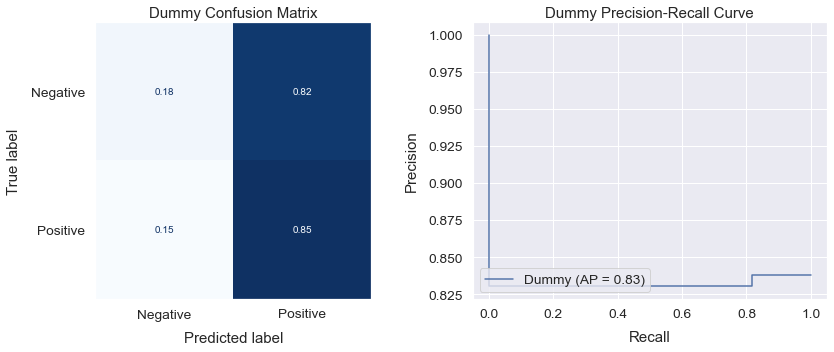

<IPython.core.display.Javascript object>

In [32]:
pipe.fit(X_train, y_train)
dummy_rep, dummy_cm, dummy_prc = eval_model(pipe, "Dummy")

## Baseline Model: Random Forest

I begin by training a `BalancedRandomForestClassifier` from the [Imbalanced-Learn](https://imbalanced-learn.org/stable/) toolkit. I've chosen this classifier as a baseline because of its unique potential to deal with the class imbalance. It's the standard random forest algorithm with a twist: when bootstrapping datasets for each decision tree, it uses **random undersampling** instead of standard random sampling. This means that it balances the classes for each subsample by drawing fewer samples from the majority class.

The weakness of undersampling is that it potentially throws away a large amount of data from the majority class. However, since undersampling is performed for each tree in the forest, observations from the majority class have multiple chances to be selected and taken into consideration.

In [33]:
pipe.set_params(cls=BalancedRandomForestClassifier())

Pipeline(memory='pipe_cache',
         steps=[('vec', FreqVectorizer()),
                ('cls', BalancedRandomForestClassifier())],
         verbose=True)

<IPython.core.display.Javascript object>

[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.7s


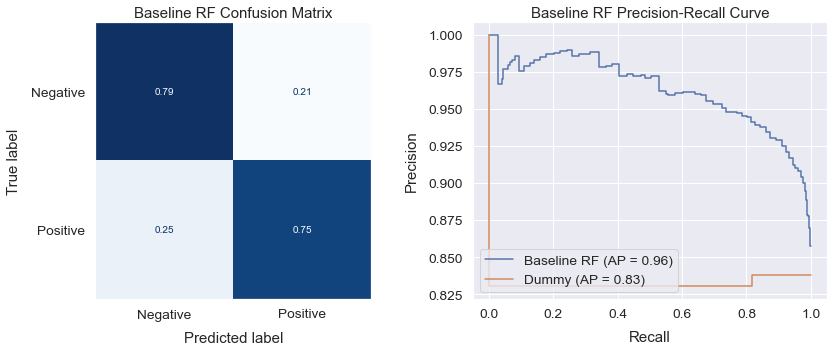

<IPython.core.display.Javascript object>

In [34]:
pipe.fit(X_train, y_train)
base_rep, base_cm, base_prc = eval_model(
    pipe, "Baseline RF", compare_curves=[dummy_prc]
)

Not bad for a baseline! Note that the confusion matrix has a strong diagonal with strong negative recall in particular. It couldn't contrast more with the dummy model's confusion matrix. Accordingly, it also has much higher macro-average recall than the dummy, and a healthy precision-recall curve.

## Adding `VaderVectorizer`

Next, I create a `FeatureUnion` which concatenates the output of `FreqVectorizer` with that of my custom `VaderVectorizer`.

`VaderVectorizer` extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). It's essentially a wrapper around the VADER tools found in NLTK. VADER analysis produces 4 scores: positive, neutral, negative, and compound. These are the 4 features in the matrix output by the vectorizer.

In [35]:
fu = FeatureUnion(
    [
        ("frq", FreqVectorizer()),
        ("vad", VaderVectorizer()),
    ],
    verbose=True,
)
fu

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


FeatureUnion(transformer_list=[('frq', FreqVectorizer()),
                               ('vad', VaderVectorizer())],
             verbose=True)

<IPython.core.display.Javascript object>

In [36]:
pipe.set_params(vec=fu)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq', FreqVectorizer()),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('cls', BalancedRandomForestClassifier())],
         verbose=True)

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 2 of 2) Processing cls, total=   0.7s


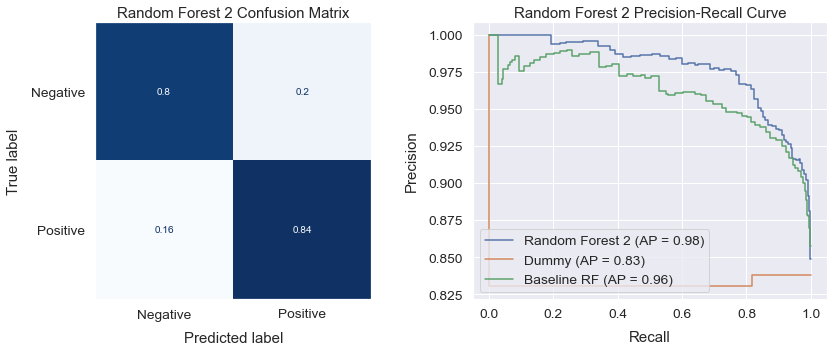

<IPython.core.display.Javascript object>

In [37]:
pipe.fit(X_train, y_train)
rf_rep, rf_cm, rf_prc = eval_model(
    pipe,
    "Random Forest 2",
    compare_curves=[dummy_prc, base_prc],
)

The macro-average recall is notably higher and the precision-recall curve is significantly wider than the baseline. As expected, the addition of `VaderVectorizer` is a major improvement.


## Selecting the Best Classifier

I started with `BalancedRandomForestClassifier` because I intuitively thought it would perform well, and it has. Nevertheless, I want to run a broad search over the hyperparameter space of multiple different classifiers. I will also try random undersampling and random oversampling with each of them.

The first step is to extend the pipeline to contain a resampler slot.

In [38]:
pipe = Pipeline(
    [
        ("vec", fu),
        ("res", "passthrough"),
        ("cls", BalancedRandomForestClassifier()),
    ],
    memory="pipe_cache",
    verbose=True,
)
pipe

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq', FreqVectorizer()),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('res', 'passthrough'),
                ('cls', BalancedRandomForestClassifier())],
         verbose=True)

<IPython.core.display.Javascript object>

I'll also include the basic `FreqVectorizer` options in the search space. This will determine whether the vectors are binary occurrence, count, TF\*IDF, binary\*IDF, or some other variant.

In [39]:
tfidf_grid = {
    "vec__frq__binary": [True, False],
    "vec__frq__norm": ["l2", None],
    "vec__frq__smooth_idf": [True, False],
    "vec__frq__sublinear_tf": [True, False],
    "vec__frq__use_idf": [True, False],
}
tfidf_grid

{'vec__frq__binary': [True, False],
 'vec__frq__norm': ['l2', None],
 'vec__frq__smooth_idf': [True, False],
 'vec__frq__sublinear_tf': [True, False],
 'vec__frq__use_idf': [True, False]}

<IPython.core.display.Javascript object>

Next, I lay out the parameter space for four types of classifiers: random forest, logistic regression, support-vector machine, and naive bayes.

#### Notes on the Parameter Space

Due to the negative range of VADER's 'Compound' score, `VaderVectorizer` must be turned off for the naive bayes classifiers. Since `VaderVectorizer` has the option of rounding scores to the nearest integer, I'll include that as an option for the other classifiers.

I only try `RandomUnderSampler` and `RandomOverSampler` for now. If one of these finds its way into the best pipeline, I'll try out more sophisticated methods like `SMOTE`.

I opt to use 'liblinear' as the solver for `LogisticRegression` because it works well on small datasets and offers both L1 and L2 regularization.

In [40]:
classif_grid = [
    {
        "cls": [BalancedRandomForestClassifier()],
        "cls__n_estimators": sp.stats.randint(100, 1000),
        "cls__criterion": ["gini", "entropy"],
        "cls__max_depth": sp.stats.randint(10, 2000),
        "cls__min_samples_split": sp.stats.uniform(),
        "cls__min_samples_leaf": sp.stats.loguniform(1e-4, 0.25),
        "cls__replacement": [True, False],
        "res": ["passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [LogisticRegression(solver="liblinear")],
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__penalty": ["l1", "l2"],
        "cls__fit_intercept": [True, False],
        "cls__class_weight": ["balanced", None],
        "res": [RandomUnderSampler(), RandomOverSampler(), "passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [SVC()],
        "cls__C": sp.stats.loguniform(1e-4, 1e4),
        "cls__kernel": ["linear", "poly", "rbf", "sigmoid"],
        "cls__shrinking": [True, False],
        "cls__break_ties": [True, False],
        "cls__class_weight": ["balanced", None],
        "res": [RandomOverSampler(), RandomUnderSampler(), "passthrough"],
        "vec__vad__round_scores": [True, False],
        **tfidf_grid,
    },
    {
        "cls": [ComplementNB(), MultinomialNB(), BernoulliNB()],
        "cls__alpha": sp.stats.loguniform(1e-4, 1e4),
        "res": [RandomOverSampler(), RandomUnderSampler(), "passthrough"],
        "vec__vad": ["drop"],
        **tfidf_grid,
    },
]
classif_grid

[{'cls': [BalancedRandomForestClassifier()],
  'cls__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d631d8b0>,
  'cls__criterion': ['gini', 'entropy'],
  'cls__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d4fb6040>,
  'cls__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d631da60>,
  'cls__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d67882b0>,
  'cls__replacement': [True, False],
  'res': ['passthrough'],
  'vec__vad__round_scores': [True, False],
  'vec__frq__binary': [True, False],
  'vec__frq__norm': ['l2', None],
  'vec__frq__smooth_idf': [True, False],
  'vec__frq__sublinear_tf': [True, False],
  'vec__frq__use_idf': [True, False]},
 {'cls': [LogisticRegression(solver='liblinear')],
  'cls__C': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d6788460>,
  'cls__penalty': ['l1', 'l2'],
  'cls__fit_intercept': [True, False],
  'cls__class_weight': ['balanced', None],
  'res': [RandomUnd

<IPython.core.display.Javascript object>

Next I run the search using Scikit-Learn's `RandomizedSearchCV`. My `selection.sweep` function is a wrapper around all of the Scikit-Learn search estimators which allows for easily switching between them and saving the results. Here I've specified `kind='rand'` to fit a `RandomizedSearchCV` with 10,000 candidates.

I typically prefer `RandomizedSearchCV` to `GridSearchCV` because I like to specify the number of candidates to try. Adding inconsequential hyperparameters to the parameter space has no effect on the number of candidates tried.

In [41]:
if RUN_SWEEPS:
    search = selection.sweep(
        pipe,
        classif_grid,
        n_jobs=-1,
        kind="rand",
        X=X_train,
        y=y_train,
        n_iter=10 ** 4,
        scoring="recall_macro",
        cv_dst="sweeps/classifier.joblib",
    )
    classifier_results = search.cv_results_
else:
    classifier_results = joblib.load("sweeps/classifier.joblib")

classifier_results = selection.prune_cv(classifier_results)

<IPython.core.display.Javascript object>

In [42]:
classifier_results.head(10)

param_cls            C  alpha break_ties class_weight criterion  \
0     SVC()   108.387623    NaN       True         None       NaN   
1     SVC()    19.703076    NaN       True     balanced       NaN   
2     SVC()    75.553489    NaN      False         None       NaN   
3     SVC()     3.595819    NaN       True     balanced       NaN   
4     SVC()     3.370624    NaN      False     balanced       NaN   
5     SVC()   118.422907    NaN       True         None       NaN   
6     SVC()   624.686785    NaN      False     balanced       NaN   
7     SVC()  3101.865661    NaN      False     balanced       NaN   
8     SVC()  8454.321014    NaN      False         None       NaN   
9     SVC()   102.164007    NaN       True     balanced       NaN   

  fit_intercept kernel  max_depth  min_samples_leaf  ...  norm  smooth_idf  \
0           NaN    rbf        NaN               NaN  ...    l2        True   
1           NaN    rbf        NaN               NaN  ...    l2        True   
2           NaN   poly        NaN               NaN  ...    l2        True   
3           NaN   poly        NaN               NaN  ...    l2       False   
4           NaN    rbf        NaN               NaN  ...    l2       False   
5           NaN   poly        NaN               NaN  ...    l2        True   
6           NaN   poly        NaN               NaN  ...    l2       False   
7           NaN   poly        NaN               NaN  ...    l2       False   
8           NaN   poly        NaN               NaN  ...    l2        True   
9           NaN   poly        NaN               NaN  ...    l2        True   

  sublinear_tf use_idf  vad round_scores  \
0         True    True  NaN        False   
1         True    True  NaN        False   
2         True    True  NaN        False   
3        False   False  NaN        False   
4        False    True  NaN         True   
5         True   False  NaN        False   
6        False   False  NaN        False   
7        False   False  NaN        False   
8        False   False  NaN        False   
9         True    True  NaN        False   

                                              params mean_fit_time  \
0  {'cls': SVC(), 'cls__C': 108.3876234609627, 'c...      0.330799   
1  {'cls': SVC(), 'cls__C': 19.703075707568555, '...      0.337223   
2  {'cls': SVC(), 'cls__C': 75.55348904699694, 'c...      0.286599   
3  {'cls': SVC(), 'cls__C': 3.595818511081092, 'c...      0.323740   
4  {'cls': SVC(), 'cls__C': 3.370623837810783, 'c...      0.324798   
5  {'cls': SVC(), 'cls__C': 118.42290693610798, '...      0.310527   
6  {'cls': SVC(), 'cls__C': 624.6867851737038, 'c...      0.317598   
7  {'cls': SVC(), 'cls__C': 3101.865660946222, 'c...      0.328406   
8  {'cls': SVC(), 'cls__C': 8454.321013802326, 'c...      0.343416   
9  {'cls': SVC(), 'cls__C': 102.16400718875725, '...      0.362909   

   mean_score  rank_score  
0    0.782379           1  
1    0.781011           2  
2    0.780357           3  
3    0.779486           4  
4    0.778957           5  
5    0.778491           6  
6    0.778491           6  
7    0.778491           6  
8    0.778491           6  
9    0.777823          10  

[10 rows x 27 columns]

<IPython.core.display.Javascript object>

## Fitting an SVM

In [43]:
pipe.set_params(**classifier_results.loc[1, "params"], cls__probability=True)

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq',
                                                 FreqVectorizer(binary=True,
                                                                norm='l2',
                                                                sublinear_tf=True,
                                                                use_idf=True)),
                                                ('vad', VaderVectorizer())],
                              verbose=True)),
                ('res', RandomUnderSampler()),
                ('cls',
                 SVC(C=19.703075707568555, break_ties=True,
                     class_weight='balanced', probability=True))],
         verbose=True)

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.6s


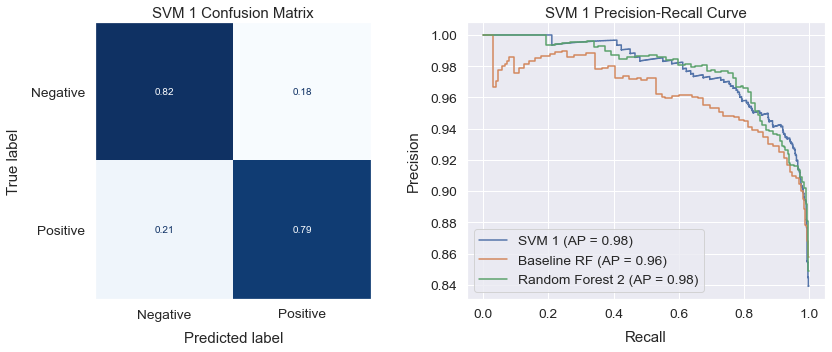

<IPython.core.display.Javascript object>

In [44]:
pipe.fit(X_train, y_train)
svm1_rep, svm1_cm, svm1_prc = eval_model(
    pipe, "SVM 1", compare_curves=[base_prc, rf_prc]
)

It's a slight improvement in macro recall, and the precision-recall curve is marginally wider than that of Random Forest 2. The biggest change seems to be the high negative recall.

## Tuning the Preprocessing

First I define some stopwords for this particular dataset which I'd like to try out.

In [45]:
my_stop = {
    "america",
    "austin",
    "link",
    "mention",
    "southbysouthwest",
    "sxsw",
    "sxswi",
    "tweet",
    "twitter",
}

my_stop

{'america',
 'austin',
 'link',
 'mention',
 'southbysouthwest',
 'sxsw',
 'sxswi',
 'tweet',
 'twitter'}

<IPython.core.display.Javascript object>

Next I lay out the preprocessing hyperparameter space for `FreqVectorizer`. My `FreqVectorizer` has built-in lemmatization with NLTK's `WordnetLemmatizer`, as well as the ability to mark words between a negation term and sentence punctuation. I'll try both of these options as well as others which I've added to Scikit-Learn's `TfidfVectorizer`.

In [46]:
preproc_grid = {
    "vec__frq__stop_words": [my_stop, "nltk_english", None],
    "vec__frq__tokenizer": [
        nltk.word_tokenize,
        nltk.casual_tokenize,
        nltk.wordpunct_tokenize,
        None,
    ],
    "vec__frq__ngram_range": [(1, 1), (1, 2)],
    "vec__frq__max_df": sp.stats.uniform(0.05, 0.95),
    "vec__frq__strip_numeric": [True, False],
    "vec__frq__strip_twitter_handles": [True, False],
    "vec__frq__limit_repeats": [True, False],
    "vec__frq__mark_negation": [True, False],
    "vec__frq__stemmer": ["wordnet", None],
}
preproc_grid

{'vec__frq__stop_words': [{'america',
   'austin',
   'link',
   'mention',
   'southbysouthwest',
   'sxsw',
   'sxswi',
   'tweet',
   'twitter'},
  'nltk_english',
  None],
 'vec__frq__tokenizer': [<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>,
  <function nltk.tokenize.casual.casual_tokenize(text, preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)>,
  <bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>,
  None],
 'vec__frq__ngram_range': [(1, 1), (1, 2)],
 'vec__frq__max_df': <scipy.stats._distn_infrastructure.rv_frozen at 0x199d6ec1790>,
 'vec__frq__strip_numeric': [True, False],
 'vec__frq__strip_twitter_handles': [True, False],
 'vec__frq__limit_repeats': [True, False],
 'vec__frq__mark_negation': [True, False],
 'vec__frq__stemmer': ['wordnet', None]}

<IPython.core.display.Javascript object>

Next I run a randomized search over `preproc_grid` with 1000 candidates. That should be enough to optimize the preprocessing.

In [47]:
if RUN_SWEEPS:
    search = selection.sweep(
        pipe,
        preproc_grid,
        n_jobs=-1,
        kind="rand",
        X=X_train,
        y=y_train,
        n_iter=1000,
        scoring="recall_macro",
        cv_dst="sweeps/preproc.joblib",
    )
    preproc_results = search.cv_results_
else:
    preproc_results = joblib.load("sweeps/preproc.joblib")

preproc_results = selection.prune_cv(preproc_results)

<IPython.core.display.Javascript object>

In [48]:
preproc_results.head(10)

limit_repeats  mark_negation    max_df ngram_range  stemmer  \
0           True           True  0.452590      (1, 1)     None   
1           True           True  0.977528      (1, 1)  wordnet   
2           True           True  0.811677      (1, 1)  wordnet   
3           True           True  0.773526      (1, 1)  wordnet   
4          False           True  0.249638      (1, 1)  wordnet   
5           True           True  0.126879      (1, 1)  wordnet   
6           True           True  0.315786      (1, 1)  wordnet   
7          False           True  0.526762      (1, 1)  wordnet   
8           True           True  0.945616      (1, 1)     None   
9          False           True  0.758515      (1, 1)     None   

                                          stop_words  strip_numeric  \
0                                       nltk_english          False   
1  {sxswi, twitter, sxsw, america, southbysouthwe...           True   
2  {sxswi, twitter, sxsw, america, southbysouthwe...          False   
3  {sxswi, twitter, sxsw, america, southbysouthwe...          False   
4  {sxswi, twitter, sxsw, america, southbysouthwe...          False   
5  {sxswi, twitter, sxsw, america, southbysouthwe...          False   
6                                               None          False   
7                                               None          False   
8                                       nltk_english           True   
9  {sxswi, twitter, sxsw, america, southbysouthwe...          False   

   strip_twitter_handles                                          tokenizer  \
0                  False     <function word_tokenize at 0x00000199C4A4A8B0>   
1                  False     <function word_tokenize at 0x00000199C4A4A8B0>   
2                   True     <function word_tokenize at 0x00000199C4A4A8B0>   
3                   True     <function word_tokenize at 0x00000199C4A4A8B0>   
4                  False     <function word_tokenize at 0x00000199C4A4A8B0>   
5                   True  <bound method RegexpTokenizer.tokenize of Word...   
6                  False   <function casual_tokenize at 0x00000199C49DB940>   
7                  False   <function casual_tokenize at 0x00000199C49DB940>   
8                   True     <function word_tokenize at 0x00000199C4A4A8B0>   
9                   True   <function casual_tokenize at 0x00000199C49DB940>   

                                              params  mean_fit_time  \
0  {'vec__frq__limit_repeats': True, 'vec__frq__m...       3.326375   
1  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.399600   
2  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.205640   
3  {'vec__frq__limit_repeats': True, 'vec__frq__m...       9.219135   
4  {'vec__frq__limit_repeats': False, 'vec__frq__...       8.764399   
5  {'vec__frq__limit_repeats': True, 'vec__frq__m...       8.180685   
6  {'vec__frq__limit_repeats': True, 'vec__frq__m...       8.840783   
7  {'vec__frq__limit_repeats': False, 'vec__frq__...       8.368999   
8  {'vec__frq__limit_repeats': True, 'vec__frq__m...       3.332243   
9  {'vec__frq__limit_repeats': False, 'vec__frq__...       2.919505   

   mean_score  rank_score  
0    0.802835           1  
1    0.799584           2  
2    0.798919           3  
3    0.798919           3  
4    0.798651           5  
5    0.798255           6  
6    0.796869           7  
7    0.795950           8  
8    0.795445           9  
9    0.795048          10

<IPython.core.display.Javascript object>

Looks like `mark_negation=True` won out pretty robustly, which doesn't surprise me. `nltk.word_tokenize` is also a clear winner, as is `ngram_range=(1, 1)`.

## Fitting a Second SVM

Next I set the best parameters and fit another model. I'm anticipating some improvement.

In [49]:
pipe.set_params(**preproc_results.loc[0, "params"])

Pipeline(memory='pipe_cache',
         steps=[('vec',
                 FeatureUnion(transformer_list=[('frq',
                                                 FreqVectorizer(binary=True,
                                                                limit_repeats=True,
                                                                mark_negation=True,
                                                                max_df=0.4525897144046643,
                                                                norm='l2',
                                                                stop_words='nltk_english',
                                                                sublinear_tf=True,
                                                                tokenizer=<function word_tokenize at 0x00000199C4A4A8B0>,
                                                                use_idf=True)),
                                                ('vad', VaderVectorizer())],
                          

<IPython.core.display.Javascript object>

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.5s


C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


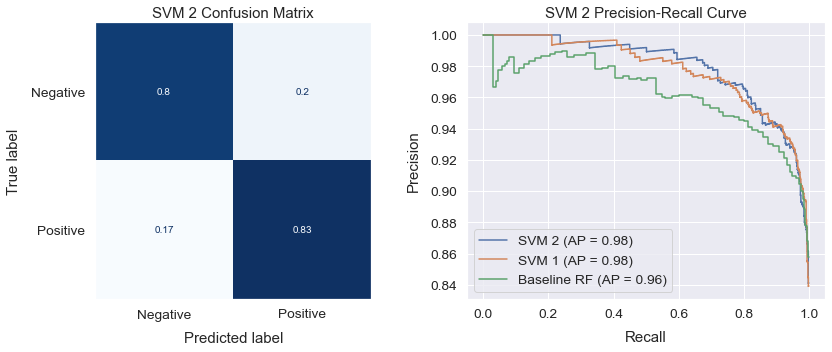

<IPython.core.display.Javascript object>

In [50]:
pipe.fit(X_train, y_train)
svm2_rep, svm2_cm, svm2_prc = eval_model(
    pipe, "SVM 2", compare_curves=[svm1_prc, base_prc]
)

There's a significant increase in macro recall, and the precision-recall curve is slightly wider than that of SVM 1.

It doesn't seem like I'm going to be able to improve much over this model, at least by conventional means. One possibility would be to use a `StackingClassifier` to combine the results of multiple different classifiers. Rather than go down that rabbit hole, I think I'll try fine-tuning a pre-trained neural network. The latter seems more promising, especially given the small size of the dataset. A pre-trained network will bring additional information with it, in a sense.

I go ahead and refit the final conventional model on the full `X` and save it.

In [51]:
pipe.fit(X, y)
joblib.dump(pipe, "models/final_svm.joblib", compress=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Pipeline] ............... (step 3 of 3) Processing cls, total=   0.8s


['models/final_svm.joblib']

<IPython.core.display.Javascript object>

## Fine-Tuning a BERT

I'm going to try using transfer learning to improve upon my previous model, and in particular, I'm going to fine-tune a pre-trained BERT model. BERT (Bidirectional Encoder Representations from Transformers) is a state of the art language understanding model trained on the union of the Toronto Book Corpus and Wikipedia. It's "bidirectional" in the sense that it takes both left and right context into account during training. It can be fine-tuned for a specific task (such as the present task) using one additional layer of neurons.

Before training the model, I need to find out the maximum sequence length for my dataset. I do this by tokenizing it with the BERT tokenizer and finding the maximum length.

In [52]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)
df["text"].map(bert_tokenizer.tokenize).str.len().max()

50

<IPython.core.display.Javascript object>

I use [this](https://github.com/charles9n/bert-sklearn) Scikit-Learn wrapper for the Huggingface Transformers port of Google's BERT. The underlying model is a PyTorch model.

I start with the default hyperparameters, except for a few which I set in advance. I arrive at the training batch size through a process of trial and error with my GPU.

In [53]:
bert = BertClassifier(
    do_lower_case=True,
    train_batch_size=28,
    max_seq_length=50,
)
bert.get_params()

Building sklearn text classifier...


{'bert_config_json': None,
 'bert_model': 'bert-base-uncased',
 'bert_vocab': None,
 'do_lower_case': True,
 'epochs': 3,
 'eval_batch_size': 8,
 'fp16': False,
 'from_tf': False,
 'gradient_accumulation_steps': 1,
 'ignore_label': None,
 'label_list': None,
 'learning_rate': 2e-05,
 'local_rank': -1,
 'logfile': 'bert_sklearn.log',
 'loss_scale': 0,
 'max_seq_length': 50,
 'num_mlp_hiddens': 500,
 'num_mlp_layers': 0,
 'random_state': 42,
 'restore_file': None,
 'train_batch_size': 28,
 'use_cuda': True,
 'validation_fraction': 0.1,
 'warmup_proportion': 0.1}

<IPython.core.display.Javascript object>

### Fitting a Baseline BERT

I fit the model with mostly default hyperparameters, then evaluate the result.

In [54]:
if FIT_BERT:
    bert.fit(X_train, y_train)
    bert.save("models/bert_baseline.bin")
else:
    bert = bert_sklearn.load_model("models/bert_baseline.bin")

bert

Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 2369, validation data size: 263


Training  :   0%|                                                                                                                                                                    | 0/85 [00:00<?, ?it/s]C:\Users\ndgig\anaconda3\envs\nlp-nn\lib\site-packages\bert_sklearn\model\pytorch_pretrained\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.21it/s]

Epoch 1, Train loss: 0.4795, Val loss: 0.4132, Val accy: 85.55%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.21it/s]

Epoch 2, Train loss: 0.4452, Val loss: 0.4666, Val accy: 85.55%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.08it/s]

Epoch 3, Train loss: 0.4307, Val loss: 0.3992, Val accy: 85.55%


BertClassifier(do_lower_case=True, label_list=array([0, 1], dtype=uint8),
               max_seq_length=50, train_batch_size=28)

<IPython.core.display.Javascript object>

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.67it/s]


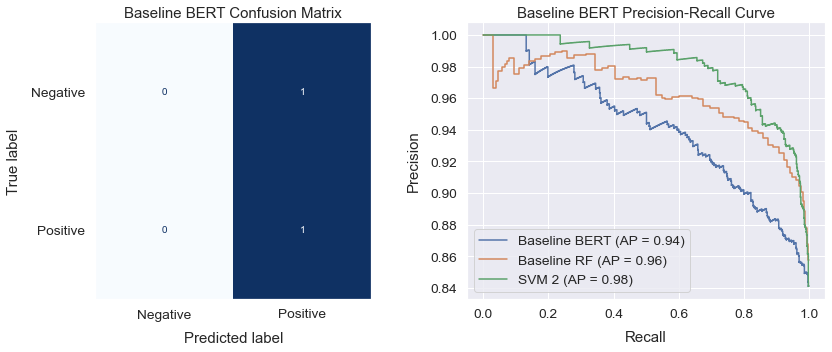

<IPython.core.display.Javascript object>

In [55]:
bert1_rep, bert1_cm, bert1_prc = eval_model(
    bert,
    "Baseline BERT",
    compare_curves=[base_prc, svm2_prc],
)

Looks terrible! It's worse than Baseline RF because it almost always predicts the positive class. Perhaps with some hand-tuning of the hyperparameters, this can be improved.

### Fitting a Second BERT

I hand-tune the hyperparameters until I'm able to create a high quality model.

In [56]:
bert.set_params(
    num_mlp_hiddens=750,
    num_mlp_layers=2,
    epochs=4,
)

BertClassifier(do_lower_case=True, epochs=4,
               label_list=array([0, 1], dtype=uint8), max_seq_length=50,
               num_mlp_hiddens=750, num_mlp_layers=2, train_batch_size=28)

<IPython.core.display.Javascript object>

I find that using a multi-layer perceptron classifier with 2 hidden layers of 750 neurons each results in a much better model. I also set it to traverse the corpus 4 times.

In [57]:
if FIT_BERT:
    bert.fit(X_train, y_train)
    bert.save("models/bert_train.bin")
else:
    bert = bert_sklearn.load_model("models/bert_train.bin")

bert

Loading bert-base-uncased model...
Using mlp with D=768,H=750,K=2,n=2
Loading Pytorch checkpoint
train data size: 2369, validation data size: 263


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]

Epoch 1, Train loss: 0.4606, Val loss: 0.5393, Val accy: 75.67%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.84it/s]

Epoch 2, Train loss: 0.2096, Val loss: 0.3266, Val accy: 88.59%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.18it/s]

Epoch 3, Train loss: 0.0944, Val loss: 0.3390, Val accy: 89.35%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.08it/s]

Epoch 4, Train loss: 0.0545, Val loss: 0.3370, Val accy: 89.35%


BertClassifier(do_lower_case=True, epochs=4,
               label_list=array([0, 1], dtype=uint8), max_seq_length=50,
               num_mlp_hiddens=750, num_mlp_layers=2, train_batch_size=28)

<IPython.core.display.Javascript object>

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.53it/s]


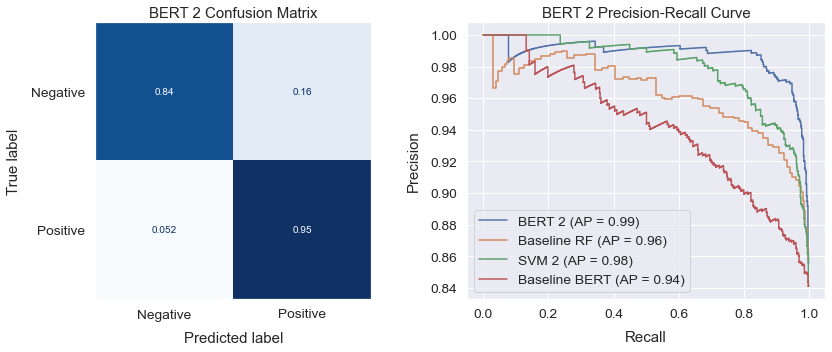

<IPython.core.display.Javascript object>

In [58]:
bert2_rep, bert2_cm, bert2_prc = eval_model(
    bert,
    "BERT 2",
    compare_curves=[base_prc, svm2_prc, bert1_prc],
)

It's a major improvement, with the highest macro recall I've seen yet. The precision-recall curve is much wider than the final conventional model, SVM 2, and the average precision is up to 0.99. The model's accuracy score is also a nice 0.93.

### Refitting the Final Model

I'm so impressed with this last BERT model that I'll consider it my final model. Now I simply need to refit using the full `X` and `y`.

In [59]:
if FIT_BERT:
    bert.fit(X, y)
    bert.save("models/bert_final.bin")
else:
    bert = bert_sklearn.load_model("models/bert_final.bin")

bert

Loading bert-base-uncased model...
Using mlp with D=768,H=750,K=2,n=2
Loading Pytorch checkpoint
train data size: 3159, validation data size: 351


Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.78it/s]

Epoch 1, Train loss: 0.4324, Val loss: 0.3169, Val accy: 87.75%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:10<00:00,  4.06it/s]

Epoch 2, Train loss: 0.1877, Val loss: 0.2713, Val accy: 89.74%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:11<00:00,  3.89it/s]

Epoch 3, Train loss: 0.0868, Val loss: 0.3238, Val accy: 88.60%



Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:10<00:00,  4.13it/s]

Epoch 4, Train loss: 0.0383, Val loss: 0.3148, Val accy: 89.74%


BertClassifier(do_lower_case=True, epochs=4,
               label_list=array([0, 1], dtype=uint8), max_seq_length=50,
               num_mlp_hiddens=750, num_mlp_layers=2, train_batch_size=28)

<IPython.core.display.Javascript object>

# Interpretation

Artificial neural networks are the most difficult type of model to interpret because they are comprised of interconnected layers of neurons, and the neurons have no meaning&mdash;they are just neurons. They are difficult to interpret and explain in much the same way that a biological brain would be. Perhaps experts can glean something from the activity inside a neural network in a controlled setting, but in typical practice, they are treated as black boxes.

There are many indirect approaches to explaining the output of a neural network. One approach is to create a global surrogate model by training a conventional machine learning model on the output of a neural network. Another approach is to create local surrogate models which approximate the neural network's behavior in the vicinity of a particular example. There are many other approaches as well.

## Bigram Analysis

For my purposes, I am much more interested in what the model says about the data than in the model itself. I will start by searching for bigrams in the text and predicting probabilities for them.

In [84]:
# Add some hashtags to stopwords
my_stop |= {"#sxsw", "#sxswi", "#austin", "#america"}
ngrams = lang.scored_bigrams(
    df["text"],
    preprocessor=lambda x: x.lower(),
    stopwords=my_stop,
    tokenizer=nltk.casual_tokenize,
    min_freq=5,
    metric="pmi",
)

ngrams = ngrams.loc[lambda x: x > x.quantile(0.75)].copy()
ngrams.index = ngrams.index.str.join(" ")
ngrams

bigram
ice cream           13.783489
lustre pearl        13.520455
speech therapy      13.520455
exhibit hall        13.298063
alternate routes    13.298063
                      ...    
on 6th               5.457060
lot of               5.455712
forward to           5.450513
iphone 4             5.446192
i thought            5.445065
Name: score, Length: 481, dtype: float64

<IPython.core.display.Javascript object>

In [85]:
ngram_proba = pd.DataFrame(
    bert.predict_proba(ngrams.index.to_list()),
    columns=["neg", "pos"],
    index=ngrams.index,
)
ngram_proba

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  5.03it/s]


neg       pos
bigram                              
ice cream         0.262451  0.737549
lustre pearl      0.558731  0.441269
speech therapy    0.454237  0.545763
exhibit hall      0.091001  0.908999
alternate routes  0.554507  0.445493
...                    ...       ...
on 6th            0.803549  0.196451
lot of            0.613672  0.386328
forward to        0.029516  0.970484
iphone 4          0.170954  0.829046
i thought         0.992772  0.007228

[481 rows x 2 columns]

<IPython.core.display.Javascript object>

### Top Bigrams for the Positive Class
I make a wordcloud below using the positive class probabilities.

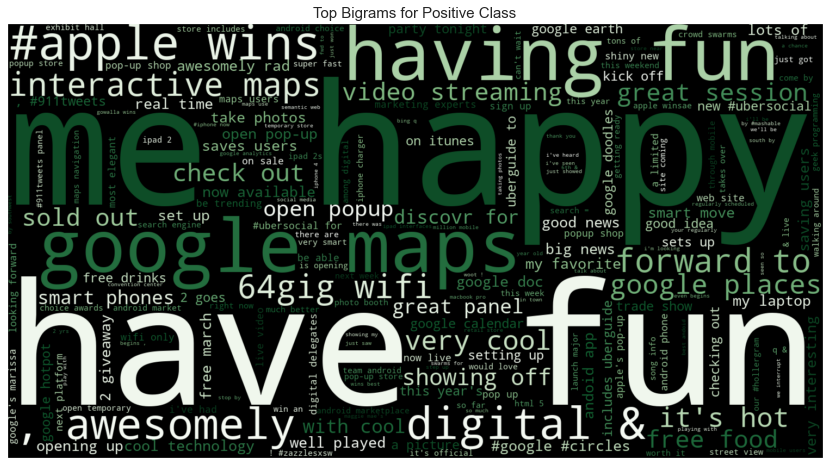

<IPython.core.display.Javascript object>

In [98]:
ax = plotting.wordcloud(
    ngram_proba["pos"],
    cmap="Greens",
    size=(15, 8),
    desat=0.7,
    random_state=35,
)
ax.set(title="Top Bigrams for Positive Class")
fig = ax.get_figure()

I notice phrases like "free food" and "free drinks", which I don't think I've seen before. Some of the other phrases are familiar from `exploratory.ipynb`, such as "shiny new" and "cool technology".

In [87]:
lang.readable_sample(
    df["text"].loc[lambda x: x.str.contains("free drinks|free food", case=False)]
)

|      | text                                                                                                                                                   |
|-----:|:-------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2097 | I go to bars and get free drinks because I have an iPhone. #doesdroid #SXSW                                                                            |
|  482 | Badgeless event! Free Drinks! UI@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de ChIAo #sxswU             |
| 7796 | Google party, don't think they are checking for badges if you say your on list. Free food and booze. #frood #sxsw CC @mention                          |
| 7550 | Thanks for the free drinks Google! #sxsw (@mention Speakeasy w/ 47 others) {link}                                                                      |
| 5542 | RT @mention Badgeless event! Free Drinks! UI@mention Heading to free Google-sponsored happy hour for Semantic Web Austin @mention Fogo de ChIAo #sxswU |
| 2846 | Free coffee by company a, free drinks on company b, free food at company c. All money saved goes to Apple. Life at #SXSW. ;)                           |
| 7795 | Google Party is at GSD&M (Google Map it). #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!                      |
| 7181 | Come! "@mention Google Party is at GSD&M #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!"                      |
| 5851 | RT @mention Google Party is at GSD&M (Google Map it). #SXSW badge gets u in. Free food, drinks, music. Big place. No line. Great party. Come!          |

<IPython.core.display.Javascript object>

Looks like Google had a party with free food and drinks.

I'll use LIME to examine one of these tweets. LIME is a tool which creates a local surrogate model to approximate a model's predictions around a particular example.

In [88]:
expl = LimeTextExplainer(
    class_names=["Negative", "Positive"],
    # I use nltk.casual_tokenize because BERT tokenizer raises errors
    split_expression=nltk.casual_tokenize,
    # Consider word order
    bow=False,
    # Mask string from BERT tokenizer
    mask_string="[MASK]",
)
expl_free_food = expl.explain_instance(df.at[7796, "text"].lower(), bert.predict_proba)
expl_free_food.show_in_notebook()

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:28<00:00, 21.58it/s]


<IPython.core.display.Javascript object>

It looks like the word "free" is especially associated with the positive class. That's hardly surprising. LIME doesn't seem to provide much additional insight for my purposes. Anyway, I'll definitely recommend that Apple give away free food and drinks, as Google did at this party.

### Top Bigrams for the Negative Class

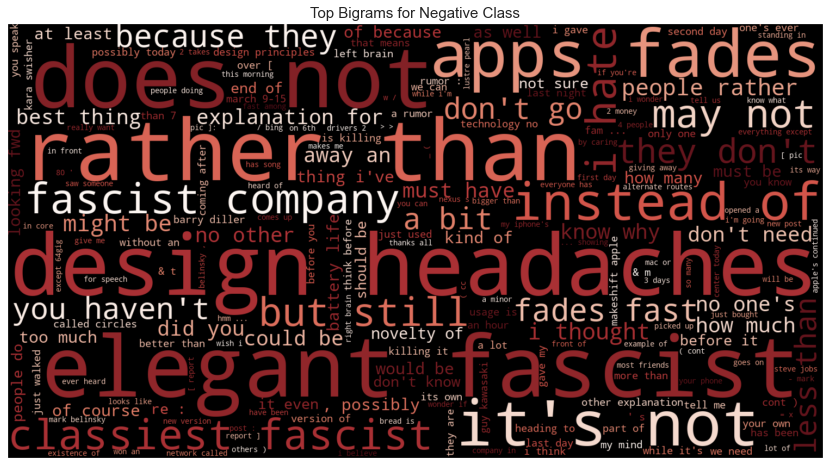

<IPython.core.display.Javascript object>

In [96]:
ax = plotting.wordcloud(
    ngram_proba["neg"],
    cmap="Reds",
    size=(15, 8),
    desat=0.7,
    random_state=5,
)
ax.set(title="Top Bigrams for Negative Class")
fig = ax.get_figure()

### Brand Bigrams

In [90]:
brand_ngrams = lang.stratified_ngrams(
    df,
    preprocessor=partial(lang.strip_punct, exclude="'#@"),
    tokenizer=partial(nltk.casual_tokenize, preserve_case=False, strip_handles=True),
    text="text",
    stopwords=my_stop,
    cat="object_of_emotion",
    min_freq=3,
    select_best=0.25,
)
brand_ngrams = (
    brand_ngrams.sort_values("score", ascending=False)
    .drop_duplicates(subset=["bigram"])
    .set_index("bigram")
)
brand_ngrams.index = brand_ngrams.index.str.join(" ")
brand_ngrams

score    object_of_emotion
bigram                                             
deviantart buys      12.468200                 iPad
tests muro           12.468200                 iPad
muro drawing         12.468200                 iPad
promotion #chevysmc  12.468200                 iPad
shameless promotion  12.468200                 iPad
...                        ...                  ...
i have                5.630350              Android
excited to            5.417356              Android
sampler on            5.259133  Other Apple Product
is now                5.238032              Android
a big                 5.231800              Android

[672 rows x 2 columns]

<IPython.core.display.Javascript object>

In [91]:
def plot_brand_clouds(
    brand,
    model=bert,
    brand_ngrams=brand_ngrams,
    cmap=("Reds", "Greens"),
    size=(10, 5),
    ncols=2,
    max_font_size=None,
    random_state=156,
    **kwargs,
):
    scored_ngrams = brand_ngrams.loc[
        lambda x: x.object_of_emotion == brand, "score"
    ].copy()

    columns = [f"{brand}: Negative", f"{brand}: Positive"]
    ngram_proba = pd.DataFrame(
        model.predict_proba(scored_ngrams.index.to_list()),
        columns=columns,
        index=scored_ngrams.index,
    )

    fig = plotting.wordcloud(
        ngram_proba,
        cmap=list(cmap),
        size=size,
        ncols=ncols,
        max_font_size=max_font_size,
        random_state=random_state,
        **kwargs,
    )
    #     fig.savefig(dst)
    return fig

<IPython.core.display.Javascript object>

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:10<00:00,  1.62it/s]


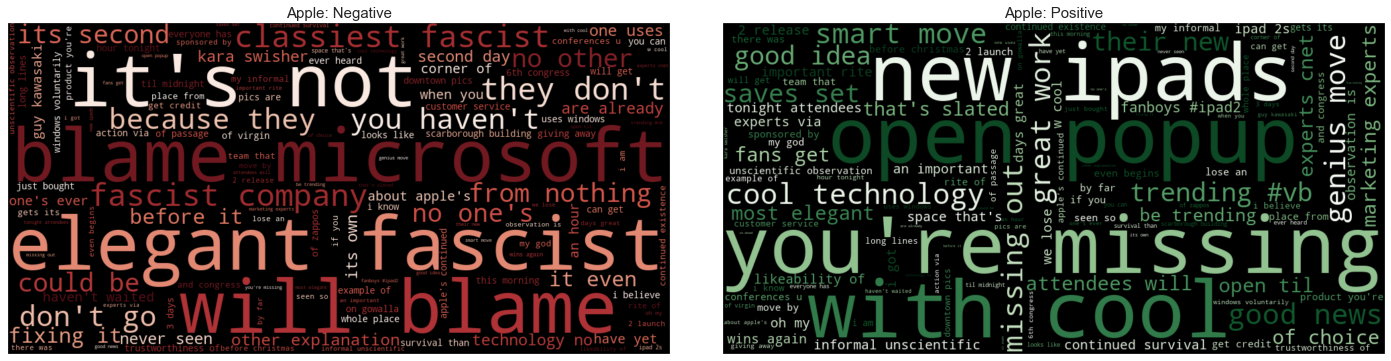

<IPython.core.display.Javascript object>

In [92]:
fig = plot_brand_clouds("Apple")

In [93]:
lang.readable_sample(
    df["text"].loc[lambda x: x.str.contains("blame microsoft", case=False)]
)

|      | text                                                                                                                                         |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------|
| 6887 | RT @mention We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas.             |
| 4426 | We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas.                         |
| 6621 | RT @mention RT @mention We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas. |
| 6888 | RT @mention We lose hour 2nite. #SxSW attendees will blame Microsoft, Apple will get credit 4 fixing it b4 Christmas.                        |

<IPython.core.display.Javascript object>

Predicting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.65it/s]


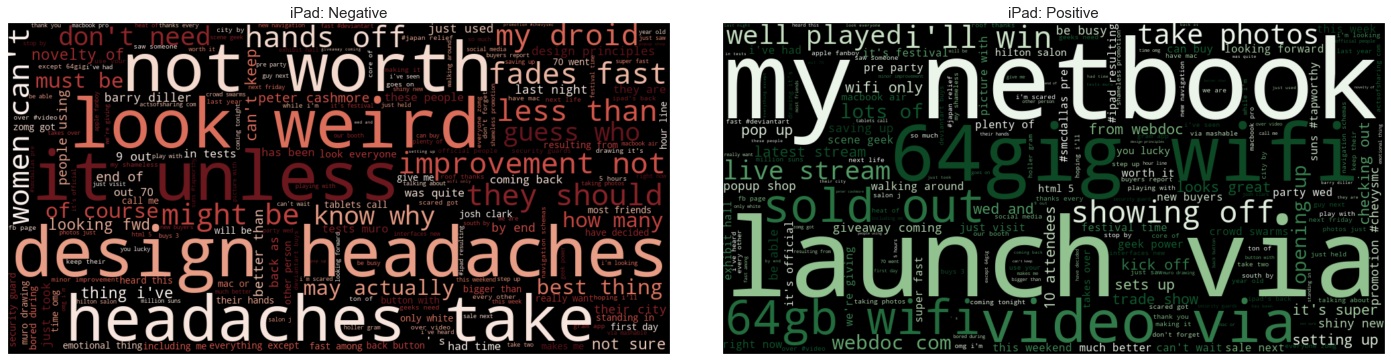

<IPython.core.display.Javascript object>

In [94]:
fig = plot_brand_clouds("iPad")

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.64s/it]


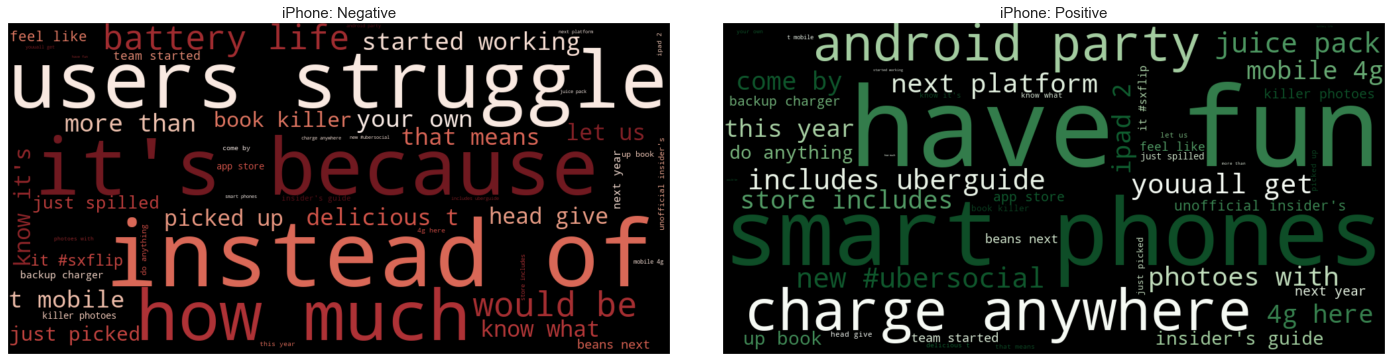

<IPython.core.display.Javascript object>

In [95]:
fig = plot_brand_clouds("iPhone")

# Recommendations

See [exploratory.ipynb](exploratory.ipynb) for more of the investigation which led to my recommendations.

#### 1. Try to shake your authoritarian image by ostensibly allowing end-users more freedom.

People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. Send the message that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

#### 2. Do something to improve the iPhone's battery life and turn it into a marketing campaign.

There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.

#### 3. Open another temporary popup store for your next big product launch.

The iPad 2 popup store was a roaring success, and people couldn't stop talking about it. Terms like 'shiny new', 'jealous', and 'cool technology' were closely associated with the iPad 2 and popup store.

#### 4. Provide free refreshments at your events.

There was a lot of excitement about the free food and drinks Google offered at their party. Free refreshments go a long way to generate good will, so I recommend providing them at at least some of your events.

# Future Work

### Stacking Classifiers

After experimenting a little with Scikit-Learn's `StackingClassifier`, it's clear to me that I could develop a more accurate conventional model this way. The `StackingClassifier` trains several classifiers on the data and then trains a final classifier on the concatenated output of those classifiers. It also allows you to pass the training data to your final estimator, so the final estimator is trained both on prior data and the predictions of the classifier ensemble.

### Bertweet

A [variant](https://huggingface.co/transformers/model_doc/bertweet.html) of BERT exists which is designed specifically for English tweets. I have not had a chance to try it yet, but I suspect it could outperform my final model.

# Conclusion

I created an accurate model, at around 93% accuracy. The dataset is small, noisy, and not particularly well labeled. Nevertheless, I'm confident that I can increase the accuracy by using Bertweet.

Through interpreting my model and conducting exploratory analysis in [exploratory.ipynb](exploratory.ipynb), I arrived at four recommendations. First, you should publicly relinquish a small amount of control over your products to send the message that you care about individual freedom (and aren't a "fascist company"). Second, you should improve the iPhone's battery life and turn that into a rallying point for a marketing campaign. People are really concerned about the iPhone's battery life. Third, you should repeat the temporary popup store for your next big product launch. There was an overwhelming amount of chatter about the iPad 2 popup store. And fourth, you should provide free refreshments at some of your events.